In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from scipy.stats import norm 
import lightgbm as lgb
from arch import arch_model
from scipy.stats import gaussian_kde

In [2]:
#get the data
symbol = "^GSPC"
data = yf.download(symbol, start="1984-10-01", end="2022-10-01")


[*********************100%***********************]  1 of 1 completed


In [3]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1984-10-01,166.100006,166.100006,164.479996,164.619995,164.619995,73630000
1984-10-02,164.619995,165.240005,163.550003,163.589996,163.589996,89360000
1984-10-03,163.589996,163.589996,162.199997,162.440002,162.440002,92400000
1984-10-04,162.440002,163.220001,162.440002,162.919998,162.919998,76700000
1984-10-05,162.919998,163.320007,162.509995,162.679993,162.679993,82950000
...,...,...,...,...,...,...
2022-09-26,3682.719971,3715.669922,3644.760010,3655.040039,3655.040039,4886140000
2022-09-27,3686.439941,3717.530029,3623.290039,3647.290039,3647.290039,4577740000
2022-09-28,3651.939941,3736.739990,3640.610107,3719.040039,3719.040039,4684850000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9579 entries, 1984-10-01 to 2022-09-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       9579 non-null   float64
 1   High       9579 non-null   float64
 2   Low        9579 non-null   float64
 3   Close      9579 non-null   float64
 4   Adj Close  9579 non-null   float64
 5   Volume     9579 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 523.9 KB


In [5]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,9579.000000,9579.000000,9579.000000,9579.000000,9579.000000,9.579000e+03
mean,1314.237634,1322.007048,1305.848974,1314.462093,1314.462093,2.086187e+09
std,1004.091883,1009.518518,998.017177,1004.062387,1004.062387,1.884332e+09
min,161.669998,162.119995,160.020004,161.669998,161.669998,1.499000e+07
25%,460.559998,461.929993,458.865005,460.569992,460.569992,2.855800e+08
50%,1146.189941,1154.969971,1138.959961,1146.540039,1146.540039,1.447500e+09
75%,1560.339966,1564.825012,1551.754944,1561.250000,1561.250000,3.610615e+09
max,4804.509766,4818.620117,4780.040039,4796.560059,4796.560059,1.145623e+10


In [6]:
#Explore the NAN value in the dataset
data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [7]:
#data size
#from the closing price we calcualte the daily return 
returns = np.log(data["Close"]).diff().dropna()
print(len(returns))

9578


In [8]:
#divide data in train, validation and test 
n_test=200
print(n_test)
train = returns.iloc[:-n_test]
print(train)
train_mean = train.mean()
train_std = train.std()

#z-Normalization
train = (train-train_mean)/train_std

n_val=int(n_test/2)
val = returns.iloc[-n_test:-n_val]
val_mean=val.mean()
val_std=val.std()

#z-Normalization
val = (val-val_mean)/val_std 

test = returns.iloc[-n_val:]
test_mean=test.mean()
test_std=test.std()

#z-Normalization
test = (test-test_mean)/test_std 

200
Date
1984-10-02   -0.006276
1984-10-03   -0.007055
1984-10-04    0.002951
1984-10-05   -0.001474
1984-10-08   -0.003387
                ...   
2021-12-08    0.003081
2021-12-09   -0.007207
2021-12-10    0.009504
2021-12-13   -0.009178
2021-12-14   -0.007499
Name: Close, Length: 9378, dtype: float64


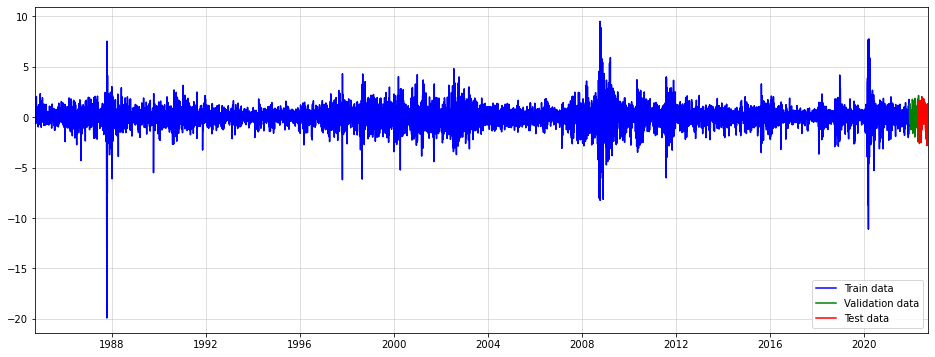

In [9]:
#plot of all the returns highlighting if that data is in train validation or test

plt.figure(figsize = (16,6))
plt.plot(train, color = "blue", label = "Train data")
plt.plot(val, color = "green", label = "Validation data")
#plt.plot(val2, color = "turquoise", label = "Validation data 2")
plt.plot(test, color = "red", label = "Test data")
plt.grid(alpha = 0.5)
plt.margins(x=0)
plt.legend()

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [11]:
#since the conditional variance has auto-regressive properties we want to find out
#what is the optimal lag, that minimizes the MAE
n_lags = 10
lags = range(1, n_lags+1)
mae_values = []

for lag in lags:
    #create the train dataset with the lags, up to 10 lags
    train_lagged = pd.concat([train**2]+[train.shift(i) for i in range(1,lag+1)],1).dropna()
    #create the validation dataset with the lags up to 10 lags 
    val_lagged = pd.concat([val**2]+[val.shift(i)for i in range(1,lag+1)],1).dropna()
    #divide target from features 
    y_train = train_lagged.iloc[:,0]
    X_train = train_lagged.iloc[:,1:]
    #divide target from features 
    y_val = val_lagged.iloc[:,0]
    X_val = val_lagged.iloc[:,1:]
    #create and fit random forest 
    forest_model_lag = RandomForestRegressor(max_depth=3, n_estimators=100, n_jobs=-1, random_state=1)
    forest_model_lag.fit(X_train.values, y_train.values)
#after having trained the model on train dataset we calculate the MAE on the validation one  
    y_pred_val = forest_model_lag.predict(X_val.values)
    mae = mean_absolute_error(y_val.values, y_pred_val)
    #list containing all the MAE for every lag 
    mae_values.append(mae)

# find the optimal lag value based on MAE
optimal_lag = lags[np.argmin(mae_values)]
maee={'Lag_1 mae':mae_values[0], 'Lag_2 mae':mae_values[1],'Lag_3 mae':mae_values[2], 'Lag_4 mae':mae_values[3],
     'Lag_5 mae':mae_values[4], 'Lag_6 mae':mae_values[5],'Lag_7 mae':mae_values[6], 'Lag_8 mae':mae_values[7],
     'Lag_9 mae':mae_values[8], 'Lag_10 mae':mae_values[9]}

print("Optimal lag value:", optimal_lag)
print(maee)


/var/folders/tg/_ckntbf90r329d5z05m0tn5h0000gn/T/ipykernel_65224/1974381542.py:9: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  train_lagged = pd.concat([train**2]+[train.shift(i) for i in range(1,lag+1)],1).dropna()
/var/folders/tg/_ckntbf90r329d5z05m0tn5h0000gn/T/ipykernel_65224/1974381542.py:11: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  val_lagged = pd.concat([val**2]+[val.shift(i)for i in range(1,lag+1)],1).dropna()
/var/folders/tg/_ckntbf90r329d5z05m0tn5h0000gn/T/ipykernel_65224/1974381542.py:9: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  train_lagged = pd.concat([train**2]+[train.shift(i) for i in range(1,lag+1)],1).dropna()
/var/folders/tg/_ckntbf90r329d5z05m0tn5h0000gn/T/ipykernel_65224/1974381542.py:11: FutureWarning: In a future version of 

Optimal lag value: 2
{'Lag_1 mae': 0.9730521653439728, 'Lag_2 mae': 0.8951554728594413, 'Lag_3 mae': 0.9042878272168541, 'Lag_4 mae': 0.9082612477426902, 'Lag_5 mae': 0.9091082848032321, 'Lag_6 mae': 0.9163159792374873, 'Lag_7 mae': 0.9190076270549544, 'Lag_8 mae': 0.9277521882379508, 'Lag_9 mae': 0.9283987390944071, 'Lag_10 mae': 0.9309340412285158}


In [12]:
#crate the train dataset with the square of the value (our variance, target) at t and the previous two values, the lags, features

train_lagged_opt = pd.concat([train**2]+[train.shift(i) for i in range(1,optimal_lag+1)],1).dropna()

/var/folders/tg/_ckntbf90r329d5z05m0tn5h0000gn/T/ipykernel_65224/1785110056.py:3: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  train_lagged_opt = pd.concat([train**2]+[train.shift(i) for i in range(1,optimal_lag+1)],1).dropna()


In [13]:
type(train_lagged_opt)

pandas.core.frame.DataFrame

In [14]:
train_lagged_opt.columns=["square", "Lag 1", "Lag 2"]

In [15]:
train_lagged_opt

,square,Lag 1,Lag 2
Date,,,
1984-10-04,0.050733,-0.643292,-0.575748
1984-10-05,0.025240,0.225239,-0.643292
1984-10-08,0.105543,-0.158871,0.225239
1984-10-09,0.077031,-0.324874,-0.158871
1984-10-10,0.042043,-0.277544,-0.324874
...,...,...,...
2021-12-08,0.055943,1.748303,0.981521
2021-12-09,0.431024,0.236523,1.748303
2021-12-10,0.630619,-0.656524,0.236523


In [16]:
#hyperparameter tuning 

# min_sample leaf
min_sample_leaf = [1, 2, 4, 8]

# max_features
max_features = ['sqrt', 'log2', None]

# max_depth
max_depth = []
for i in range (2, 9, 1):
    max_depth.append(i)
max_depth.append(None)

# min_samples_split
min_samples_split = [1, 2, 4, 8]

#n_estimators

n_estimators=[64, 96, 128, 256]


# assigning the parameters into a parameter grid
parameter_grid = {'n_estimators': n_estimators,
                 'min_samples_leaf': min_sample_leaf,
                 'min_samples_split': min_samples_split,
                 'max_features': max_features,
                 'max_depth': max_depth}

# displaying the parameters
parameter_grid

{'n_estimators': [64, 96, 128, 256],
 'min_samples_leaf': [1, 2, 4, 8],
 'min_samples_split': [1, 2, 4, 8],
 'max_features': ['sqrt', 'log2', None],
 'max_depth': [2, 3, 4, 5, 6, 7, 8, None]}

In [17]:
y_train = train_lagged_opt.iloc[:,0]
X_train = train_lagged_opt.iloc[:,1:]

forest_model = RandomForestRegressor(random_state=1)

dforgrid = GridSearchCV(estimator = forest_model,
                        param_grid = parameter_grid,
                        n_jobs = -1,
                        cv=5, scoring='neg_mean_squared_error'
                        )

# assigning the data from Subtrain dataframe into the model
dforgrid.fit(X_train, y_train)

/Users/francescocaccia/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
1920 fits failed out of a total of 7680.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1920 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/francescocaccia/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/francescocaccia/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/Users/francescocaccia/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
 

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, None],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 4, 8],
                         'min_samples_split': [1, 2, 4, 8],
                         'n_estimators': [64, 96, 128, 256]},
             scoring='neg_mean_squared_error')

In [18]:
dforBestParam = dforgrid.best_params_
dforBestParam

{'max_depth': 6,
 'max_features': 'sqrt',
 'min_samples_leaf': 8,
 'min_samples_split': 2,
 'n_estimators': 128}

In [19]:
forest_model = RandomForestRegressor(random_state=1, **dforBestParam)
forest_model.fit(X_train.values, y_train.values)

RandomForestRegressor(max_depth=6, max_features='sqrt', min_samples_leaf=8,
                      n_estimators=128, random_state=1)

In [20]:
#implement monte carlo simulation to calculate the confidence interval of our estimations 

#Set the number of samples to generate using Monte Carlo simulation.
samp_size = 50000

#Create a DataFrame with lagged values of the training set to use as input for the forest model. The number of lags used is optimal_lag.
Xt = pd.DataFrame(pd.concat([train.shift(i) for i in range(optimal_lag)],1).dropna().iloc[-1,:].values.reshape(1,-1))

#Repeat the input DataFrame samp_size times to use as input for the Monte Carlo simulation
Xt = pd.concat([Xt for _ in range(samp_size)])
Xt.columns = X_train.columns

#Set the random seed to ensure reproducibility.
np.random.seed(1)
#Create an empty list to store the samples generated using Monte Carlo simulation.
forest_samples = []


for t in range(len(test)):
    #Predict the variance using the forest model.
    pred = forest_model.predict(Xt.values).reshape(-1,1)
    #Generate samples using Monte Carlo simulation by multiplying a standard normal distribution with the predicted variance.
    samp = norm(0, 1).rvs(samp_size).reshape(-1,1)*np.sqrt(pred)
    forest_samples.append(samp)
    
    #Update the input DataFrame with the generated samples.
    Xt = pd.DataFrame(np.concatenate([np.array(samp).reshape(-1,1),Xt.values[:,:-1]],1))
    Xt.columns = X_train.columns
    
#Convert the list of samples into a numpy array.    
forest_samples_matrix = np.concatenate(forest_samples,1)
#Calculate the standard deviation of the samples for each time point.
forest_std = np.std(forest_samples_matrix,0)
#Calculate the lower 5% quantile of the samples for each time point.
forest_lower = np.quantile(forest_samples_matrix,0.05,0)
#Calculate the upper 5% quantile of the samples for each time point.
forest_upper = np.quantile(forest_samples_matrix,0.95,0)

/var/folders/tg/_ckntbf90r329d5z05m0tn5h0000gn/T/ipykernel_65224/3235691325.py:7: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  Xt = pd.DataFrame(pd.concat([train.shift(i) for i in range(optimal_lag)],1).dropna().iloc[-1,:].values.reshape(1,-1))


In [21]:
#The loss function calculates the negative log-likelihood of the data assuming a Gaussian (normal) distribution of the errors.
def gaussian_loss(y_pred, data):
    #The get_label() method is used to retrieve the true labels y_true from the data argument. 
    
    y_true = data.get_label()
    
    loglikelihood = -0.5*np.log(2*np.pi) - 0.5*y_pred - 0.5/np.exp(y_pred)*y_true**2
    #remember that boosting minimizes the loss function but we want to maximize the loglikelihood
    #thus, need to return the negative loglikelihood to the Boosting algorithm
    #also applies to gradient and hessian below
    

#"loglike": a string representing the name of the custom loss function, used for display purposes.
#-loglikelihood: the negative log-likelihood of the data, which is the value to be minimized by the gradient boosting algorithm.
#False: a flag indicating whether the custom loss function is a "metric", which is a measure of performance used to evaluate the model during training. In this case, the function is not a metric, so this flag is set to False.
    return "loglike", -loglikelihood, False

#defines the gradient and Hessian (second-order derivative) of the custom loss function gaussian_loss that was defined earlier. The gradient and Hessian are used 
#by the gradient boosting algorithm to update the model parameters during training.
def gaussian_loss_gradhess(y_pred, data):
    y_true = data.get_label()
    
    exp_pred = np.exp(y_pred)
    
    #The gradient and Hessian are calculated using the chain rule of differentiation.
    #the gradient of the negative log-likelihood 
    grad = -0.5 + 0.5/exp_pred*y_true**2 
    #the Hessian of the negative log-likelihood
    hess = -0.5/exp_pred*y_true**2
#The function returns a tuple with two elements:

#-grad: the negative gradient of the negative log-likelihood. The negative sign is added because XGBoost minimizes the loss function, so we need to maximize the negative log-likelihood by minimizing its negative.
#-hess: the negative Hessian of the negative log-likelihood. The negative sign is added for the same reason as above.
    return -grad, -hess

In [22]:
#DataFrame that contains the training data with lagged values up to the optimal lag. The first column of train_lagged is the target variable, and the other columns are the lagged features.
train_lagged = pd.concat([train]+[train.shift(i) for i in range(1,optimal_lag+1)],1).dropna()

y_train = train_lagged.iloc[:,0]
X_train = train_lagged.iloc[:,1:]
#LightGBM dataset object that is created from the training data.
train_data = lgb.Dataset(X_train.values, label=y_train.values)
param = {"num_leaves":2, "learning_rate":0.1, "seed": 1}


num_round = 1000
#trained LightGBM model. The custom loss function gaussian_loss_gradhess is used as the objective function for training, 
#and the custom evaluation function gaussian_loss is used to compute the log-likelihood during training.
#By using the custom loss function gaussian_loss_gradhess, the LightGBM model is trained to minimize the negative log-likelihood of a Gaussian distribution with mean equal to the predicted value and variance equal to the exponential of the predicted value. 
#This is useful when the target variable follows a Gaussian distribution with heteroscedasticity, meaning the variance of the target variable changes with the predicted value.
boosted_model = lgb.train(param, train_data, num_round, fobj=gaussian_loss_gradhess, feval=gaussian_loss)

np.random.seed(1)

boosted_samples = []


for t in range(len(test)):
    #This code snippet generates predictions from the trained LightGBM mode
    #The reshape() method is then called on the predicted values with the argument (-1, 1). This reshapes the 1D numpy array into a column vector with the same number of rows as the input array and a single column. 
    #The resulting column vector contains the predicted values for each row in the test set Xt.
    pred = boosted_model.predict(Xt.values).reshape(-1,1)
    #This code snippet generates random samples from a normal distribution and rescales them by the square root of the exponential of the predicted values.
    samp = norm(0, 1).rvs(samp_size).reshape(-1,1)*np.sqrt(np.exp(pred))
    boosted_samples.append(samp)

    
    #This code snippet updates the test set Xt by replacing the first column of the feature matrix with the column vector samp generated in the previous step.
    Xt = pd.DataFrame(np.concatenate([np.array(samp).reshape(-1,1),Xt.values[:,:-1]],1))
    Xt.columns = X_train.columns
    
#This code snippet concatenates a list of numpy arrays horizontally using np.concatenate() and assigns the resulting concatenated array to boosted_samples_matrix.
boosted_samples_matrix = np.concatenate(boosted_samples,1)

#calculates the standard deviation along the columns of the matrix 
boosted_std = np.std(boosted_samples_matrix,0)
#calculates the lower 5% quantile along the columns of the matrix 
boosted_lower = np.quantile(boosted_samples_matrix,0.05,0)
##calculates the upper 5% quantile along the columns of the matrix 
boosted_upper = np.quantile(boosted_samples_matrix,0.95,0)

/var/folders/tg/_ckntbf90r329d5z05m0tn5h0000gn/T/ipykernel_65224/2926333578.py:2: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  train_lagged = pd.concat([train]+[train.shift(i) for i in range(1,optimal_lag+1)],1).dropna()


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9376, number of used features: 2
[LightGBM] [Warning] Using self-defined objective function


In [23]:
#This line of code creates an ARCH (Autoregressive Conditional Heteroskedasticity) model object using the arch_model() function from the arch library.
#The arch_model() function takes several arguments, including the time series data to be modeled (train in this case), the number of lags to include in the model for the conditional mean (p=n_lags), 
#and the number of lags to include in the model for the conditional variance (q=n_lags).
am = arch_model(train, p=n_lags,q=n_lags)
#This line of code estimates the parameters of the ARCH model created in the previous line using maximum likelihood estimation. 
res = am.fit(update_freq=5)
#This line of code generates forecasts for the conditional variance of the time series using the forecast() method of the ARCHModelResult object stored in res. 
#The forecast() method takes one required argument, horizon, which specifies the number of time steps to forecast into the future. In this case, horizon is set to len(test), 
#which is the number of time steps in the test data.
forecasts = res.forecast(horizon=len(test), reindex=False).variance.values[0,:]

#This line of code generates a matrix of 50,000 simulations of the future values of the time series based on the GARCH model estimated using the arch_model function. 
#The forecast() method of the ARCHModelResult object stored in res is used to generate these simulations.
garch_samples_matrix = res.forecast(horizon=len(test), simulations = 50000, reindex=False, method = "simulation").simulations.values[0,:,:]

garch_std = np.std(garch_samples_matrix,0)
garch_lower = np.quantile(garch_samples_matrix,0.05,0)
garch_upper = np.quantile(garch_samples_matrix,0.95,0)


#This line of code uses the gaussian_kde function from the scipy.stats module to estimate the kernel density of the training data.
iid_kde = gaussian_kde(train)
#This line of code generates a matrix of 50,000 simulations of the future values of the time series based on the estimated kernel density using the gaussian_kde function.
#The resulting matrix iid_kde_samp has dimensions (50000, len(test)) and contains 50,000 simulations of the future values of the time series. Each row of the matrix represents a single simulation, and the columns represent the time steps.
iid_kde_samp = iid_kde.resample((50000*len(test))).reshape(50000,len(test))

kde_lower = np.quantile(iid_kde_samp,0.05,0)
kde_upper = np.quantile(iid_kde_samp,0.95,0)

Iteration:      5,   Func. Count:    127,   Neg. LLF: 14809.516108099822
Iteration:     10,   Func. Count:    251,   Neg. LLF: 13550.18265036796
Iteration:     15,   Func. Count:    374,   Neg. LLF: 11431.493786028488
Iteration:     20,   Func. Count:    497,   Neg. LLF: 11149.76670626904
Iteration:     25,   Func. Count:    616,   Neg. LLF: 11136.1362901956
Iteration:     30,   Func. Count:    731,   Neg. LLF: 11136.120828870024
Optimization terminated successfully    (Exit mode 0)
            Current function value: 11136.120828870024
            Iterations: 31
            Function evaluations: 753
            Gradient evaluations: 31


Text(0.5, 1.0, 'I.i.d. KDE - Test set loglikelihood: -145.11')

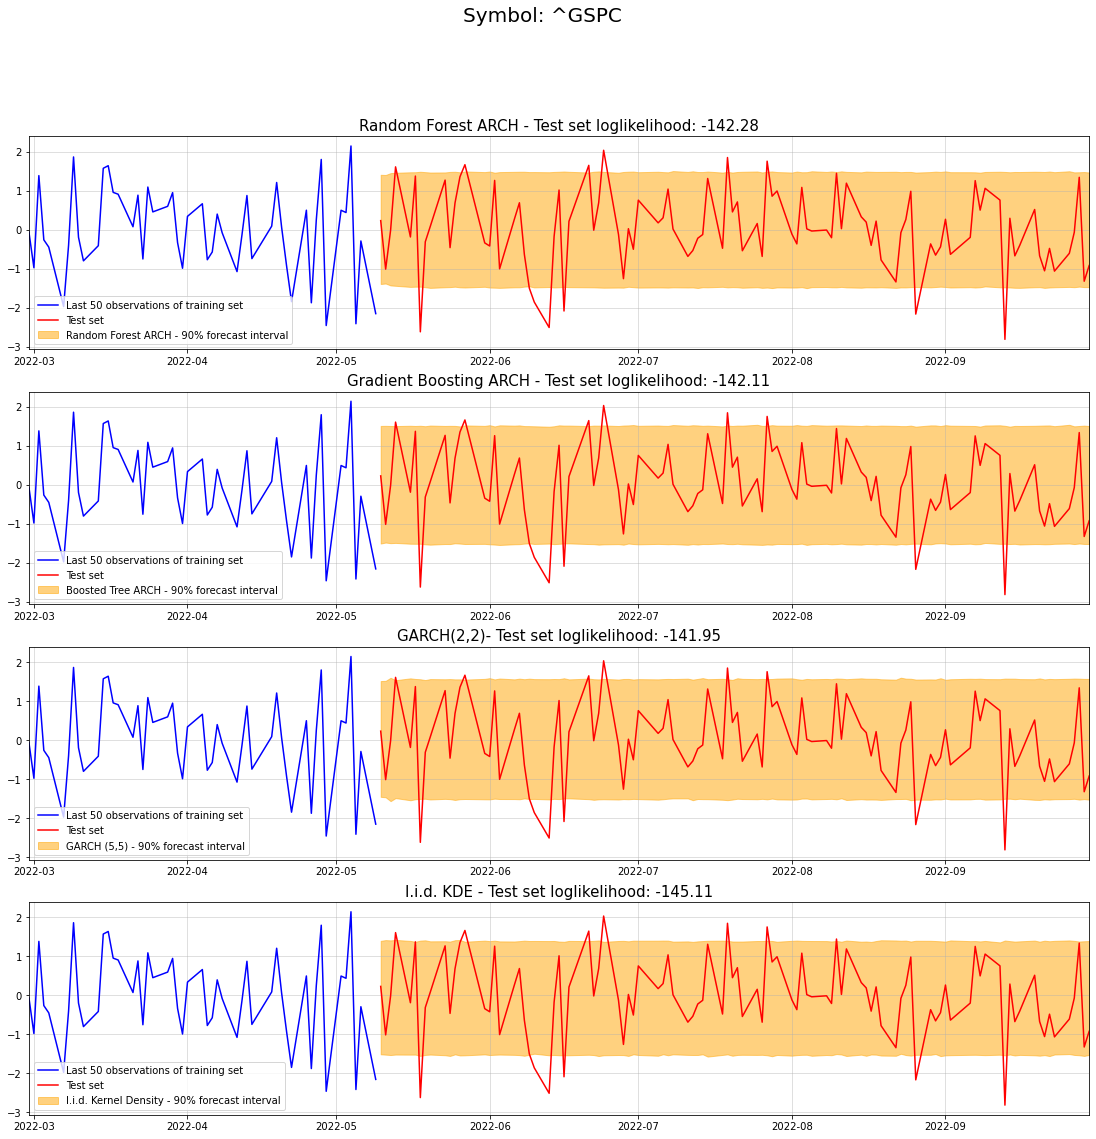

In [24]:
#computes the log probability densities of each data point in the test dataset under a kernel density estimator (KDE)
benchmark_lpdfs = [iid_kde.logpdf(test[i])[0] for i in range(len(test))]
#computes the log probability densities of each data point in the test dataset under a kernel density estimator (KDE) that was constructed using samples from a GARCH (Generalized Autoregressive Conditional Heteroscedasticity) model. 
garch_lpdfs = [gaussian_kde(garch_samples_matrix[:,i]).logpdf(test[i])[0] for i in range(len(test))]
#computes the log probability densities of each data point in the test dataset under a kernel density estimator (KDE) that was constructed using samples from a forest model. 
forest_lpdfs = [gaussian_kde(forest_samples_matrix[:,i]).logpdf(test[i])[0] for i in range(len(test))]
#This line of code computes the log probability densities of each data point in the test dataset under a kernel density estimator (KDE) that was constructed using samples from a boosted model. 
boosted_lpdfs = [gaussian_kde(boosted_samples_matrix[:,i]).logpdf(test[i])[0] for i in range(len(test))]

# creates a 2x2 grid of subplots with a shared x-axis, The grid contains four subplots and is created with the 4,1 argument, indicating four rows and one column.
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(19,18))
# set the title
st = fig.suptitle("Symbol: "+symbol, fontsize=20)

#This line of code plots a line chart of the last 50 observations of a time series on the first subplot (ax1) of the figure. 
ax1.plot(val.iloc[-50:], color = "blue", label = "Last 50 observations of training set")
#This line of code plots a line chart of the test set data on the first subplot (ax1) of the figure
ax1.plot(test, color = "red", label = "Test set")
#This line of code adds a grid to the first subplot (ax1) of the figure, with horizontal and vertical lines that extend across the entire plot. 
#The alpha argument sets the opacity of the grid lines, with a value of 0.5 indicating that the lines will be partially transparent.
ax1.grid(alpha = 0.5)
#This line of code sets the margins of the x-axis of the first subplot (ax1) to zero, using the margins() method of the Axes object. This means that there will be no extra space or padding between 
#the data and the edges of the plot, and that the x-axis will extend all the way to the edges of the plot.
ax1.margins(x=0)
#This line of code fills the area between two curves on the first subplot (ax1) of the figure, using the fill_between() method of the Axes object. The area is defined by the test.index variable (likely a pandas DatetimeIndex object) and two curves, 
#represented by the forest_lower and forest_upper variables. These curves are likely generated by a predictive model (in this case, a random forest ARCH model) and represent the lower and upper bounds of a 90% forecast interval for the test data.
ax1.fill_between(test.index, forest_lower, forest_upper, color="orange", alpha=0.5, label="Random Forest ARCH - 90% forecast interval")
ax1.legend()
#
ax1.set_title("Random Forest ARCH - Test set loglikelihood: {}".format(str(np.sum(forest_lpdfs))[:7]), fontdict={'fontsize': 15})


ax2.plot(val.iloc[-50:], color = "blue", label = "Last 50 observations of training set")
ax2.plot(test, color = "red", label = "Test set")
ax2.grid(alpha = 0.5)
ax2.margins(x=0)
ax2.fill_between(test.index, boosted_lower, boosted_upper, color="orange", alpha=0.5, label="Boosted Tree ARCH - 90% forecast interval")
ax2.legend()
ax2.set_title("Gradient Boosting ARCH - Test set loglikelihood: {}".format(str(np.sum(boosted_lpdfs))[:7]), fontdict={'fontsize': 15})


ax3.plot(val.iloc[-50:], color = "blue", label = "Last 50 observations of training set")
ax3.plot(test, color = "red", label = "Test set")
ax3.grid(alpha = 0.5)
ax3.margins(x=0)
ax3.fill_between(test.index, garch_lower, garch_upper, color="orange", alpha=0.5, label="GARCH (2,2) - 90% forecast interval")
ax3.legend()
ax3.set_title("GARCH(2,2)- Test set loglikelihood: {}".format(str(np.sum(garch_lpdfs))[:7]), fontdict={'fontsize': 15})


ax4.plot(val.iloc[-50:], color = "blue", label = "Last 50 observations of training set")
ax4.plot(test, color = "red", label = "Test set")
ax4.grid(alpha = 0.5)
ax4.margins(x=0)
ax4.fill_between(test.index, kde_lower, kde_upper, color="orange", alpha=0.5, label="I.i.d. Kernel Density - 90% forecast interval")
ax4.legend()
ax4.set_title("I.i.d. KDE - Test set loglikelihood: {}".format(str(np.sum(benchmark_lpdfs))[:7]), fontdict={'fontsize': 15})
